# Medical Insurance Cost Estimation

In this project, medical cost insurance is calculated using kNN and weighted-kNN regression with and without feature normalization. The results are analyzed using the Mean Absolute Error (MAE) technique.
You can reach the dataset with this link: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [ ]:
""" import necessary libraries"""
import numpy as np

In [ ]:
""" upload dataset from your PC, you can use different methods"""
from google.colab import files
data = files.upload()

Saving insurance.csv to insurance (1).csv


## Pre-processing

No null value exists in the dataset, so there is no need to handle this situation.

In [ ]:
import pandas as pd
datafr = pd.read_csv(list(data)[0], encoding='cp1252')

datafr.info()
datafr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


###Object Encode

Object data types need to be encoded into integers for utilization within our model.

For example, the dataset contains 2 sex values, male and female. Therefore, integer values are assigned to them, 0 and 1.

In [ ]:
datafr["sex"] = pd.Categorical(datafr["sex"])
datafr["sex"] = datafr["sex"].cat.codes.astype("int64")

datafr["smoker"] = pd.Categorical(datafr["smoker"])
datafr["smoker"] = datafr["smoker"].cat.codes.astype("int64")

datafr["region"] = pd.Categorical(datafr["region"])
datafr["region"] = datafr["region"].cat.codes.astype("int64")

datafr.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


###Min-Max Normalize

In this problem, min-max normalization needs to be utilized.

Minimum and maximum values are obtained for each column. Then, the minimum values are subtracted from the array (actual values), and each column is divided by the range (max - min).

In [ ]:
def min_max_normalize(arr):
    # Get the minimum and maximum values for each column
    min_vals = np.min(arr, axis=0)
    max_vals = np.max(arr, axis=0)

    # Subtract the minimum values from the array and divide by the range for each column
    normalized_arr = (arr - min_vals) / (max_vals - min_vals)

    return normalized_arr

## Split the dataset

Split the dataset into folds (5 fold)

In [ ]:
# Shuffle the DataFrame
datafr = datafr.sample(frac=1, random_state=42).reset_index(drop=True)

def split_kfold(data, k):
  folds = []
  size = len(data) // k

  for i in range(k):
    start = i * size
    end = (i + 1) * size if i < (k - 1) else len(data)
    folds.append(data[start:end])

  return folds

##Functions

### kNN

In [ ]:
def kNN_regression(X_pred, y_pred, X_val, k, weighted=False):
  # Calculate Euclidean distance with matrix operations for time saving
  distances = np.sqrt(np.sum((X_pred - X_val)**2, axis=1))

  # Merge distances with corresponding medical costs
  distances_zipped = sorted(zip(distances, y_pred))

  # Get medical costs of k nearest neighbors from sorted distances
  nearest_neighbors = distances_zipped[:k]

  if not weighted:
    # Calculate the unweighted average of medical costs
    predict_nearest_neighbors = np.mean([value for _, value in nearest_neighbors])
    return predict_nearest_neighbors

  else:
    # Calculate the weighted average of medical costs
    total_value = 0
    total_weight = 0

    for distance, value in nearest_neighbors:
      weight = 1 / (distance + 1)
      total_value += weight * value
      total_weight += weight

    # Avoid division by zero
    if total_weight == 0:
      return 0

    # Return the weighted average as the regression result
    return total_value / total_weight



###Mean Absolute Error

In [ ]:
def mean_absolute_error(y_test, y_pred):
  return np.mean(np.abs(y_test - y_pred))

###Cross Validation
Cross-validation is a fundamental technique used to assess the performance of machine learning models. It involves dividing the dataset into 'k' subsets or folds and systematically training and testing the model on different combinations of these folds.

In [ ]:
def cross_val(data, k, kNN, normalize, weighted):
  # Initialize an empty list to store the results of each fold.
  results = []

  # If 'normalize' flag is set to True, normalize the feature values in the dataset using min-max normalization.
  if normalize:
    data[:, :-1] = min_max_normalize(data[:, :-1])

  # Split the data into 'k' folds for cross-validation.
  folds = split_kfold(data, k)
  # Iterate through each fold for testing and training.
  for i in range(k):
    # Select the current fold as the test set and the remaining folds as the training set.
    test = folds[i]
    train = np.vstack([folds[j] for j in range(k) if j != i])

    # Split the training and testing data into features (X) and target values (y).
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]
    # Initialize an empty list to store the predicted values for the test set.
    y_pred = []

    # Iterate through each data point in the test set and make predictions using kNN regression.
    for test in X_test:
      prediction = kNN_regression(X_train, y_train, test, kNN, weighted)
      y_pred.append(prediction)

    # Calculate the mean absolute error (MAE) between the true and predicted values for the test set.
    result = mean_absolute_error(y_test, y_pred)
    # Append the MAE for the current fold to the results list.
    results.append(result)

  # Calculate and return the mean of MAE values obtained in all folds.
  return np.mean(results)

##Main

###kNN Operations
Calculate kNN and weighted-kNN for both normalized and non-normalized data using different k values: 1, 3, 5, 7, and 9.

In [ ]:
# Convert a DataFrame 'datafr' to a NumPy array 'npdatafr' for processing.
npdatafr = datafr.to_numpy()

# Define the number of folds for cross-validation and the k values to be tested.
fold = 5
k_values = [1,3,5,7,9]
# Define a list of boolean values for controlling data normalization (False: non-normalized, True: normalized).
boolean_values = [False, True]

# kNN (Unweighted)
knn_results = []
for normalized in boolean_values:
  subresults = []
  for k in k_values:
    # Call the 'cross_val' function to perform k-fold cross-validation with kNN (unweighted).
    # 'weighted' parameter is set to False.
    result = cross_val(npdatafr.copy(), fold, k, normalized, weighted = False)
    subresults.append(round(result, 3))
  # Append 'subresults' to 'knn_results' to store results for different k values and normalization settings.
  knn_results.append(subresults)

# Weighted kNN
weighted_knn_results = []
for normalized in boolean_values:
  subresults = []
  for k in k_values:
    # Call the 'cross_val' function to perform k-fold cross-validation with weighted kNN.
    # 'weighted' parameter is set to True.
    result = cross_val(npdatafr.copy(), fold, k, normalized, weighted = True)
    subresults.append(round(result, 3))
  # Append 'subresults' to 'weighted_knn_results' to store results for different k values and normalization settings.
  weighted_knn_results.append(subresults)


###Visualization

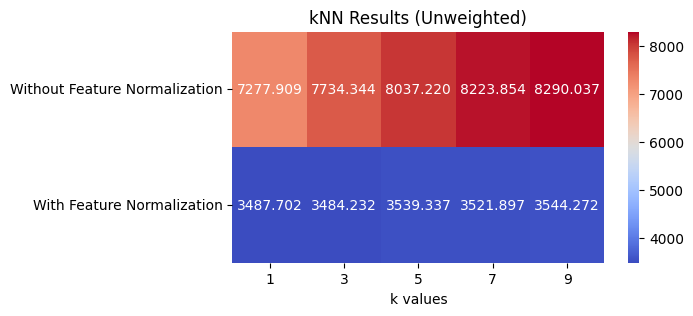

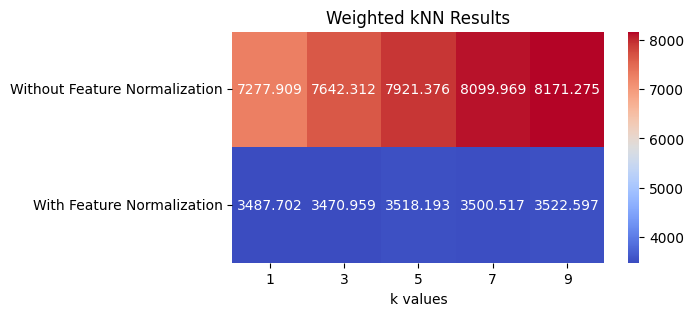

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set y_labels
y_labels = ["Without Feature Normalization", "With Feature Normalization"]

# Create a heatmap from the data
plt.figure(figsize=(6, 3))
sns.heatmap(knn_results, annot=True, cmap="coolwarm", fmt='.3f', xticklabels= k_values ,yticklabels= y_labels)

# Set axis labels and title
plt.xlabel("k values")
plt.title("kNN Results (Unweighted)")

# Show the heatmap
plt.show()

# Create a heatmap from the data
plt.figure(figsize=(6, 3))
sns.heatmap(weighted_knn_results, annot=True, cmap="coolwarm", fmt='.3f', xticklabels= k_values ,yticklabels= y_labels)

# Set axis labels and title
plt.xlabel("k values")
plt.title("Weighted kNN Results")

# Show the heatmap
plt.show()

##Conclusion

When comparing the results of our model, it becomes evident that feature normalization significantly improves performance in this context. Normalized data yields a substantially lower mean absolute error (MAE) of approximately 3500, while non-normalized data results in a notably higher MAE of around 8000.

Additionally, it's worth noting that the choice between standard kNN and weighted kNN has minimal influence on the model's performance for this specific problem. The MAE values obtained from both kNN variants are remarkably close, indicating that the type of kNN applied doesn't lead to significant differences in predictive accuracy.

Furthermore, when investigating the impact of the 'k' value in kNN, it's evident that higher 'k' values tend to result in progressively less accurate predictions. This underscores the importance of carefully selecting an appropriate 'k' value, as overly large 'k' values may lead to a loss in model performance. Therefore, a balanced choice of 'k' is crucial to strike the right trade-off between accuracy and model complexity.

The computation time is around 30 seconds for over 1300 data points with 5-fold cross-validation, using both normalized and non-normalized data, for both standard k-NN and weighted k-NN methods in total.